In [1]:
import torch
import torchvision
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [2]:
smooth = 1.

def dice(y_true, y_pred):
    y_true_f = torch.flatten(y_true[i,:,:,:])
    y_pred_f = torch.flatten(y_pred[i,:,:,:])
    intersection = torch.sum(y_true_f * y_pred_f)
    r=((2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth))
    print(r)
    return r


def dice_loss(y_true, y_pred):
    return 1.0 - dice(y_true, y_pred)

In [3]:
path='/Users/karthik/nlpipe/numpys/'
train_xp=path+'X_train/'
train_yp=path+'y_train/'
test_xp=path+'X_test/'
test_yp=path+'y_test/'
from os import listdir
from os.path import isfile, join
train_xf = [f for f in listdir(train_xp) if isfile(join(train_xp, f))]
train_yf = [f for f in listdir(train_yp) if isfile(join(train_yp, f))]
test_xf = [f for f in listdir(test_xp) if isfile(join(test_xp, f))]
test_yf = [f for f in listdir(test_yp) if isfile(join(train_yp, f))]
train_x=[]
train_y=[]
test_x=[]
test_y=[]
for i,f in enumerate(train_xf):
    try:
        x=np.load(train_xp+f).astype(np.float32).reshape(-1,560, 640)
        y=np.load(train_yp+f).astype(np.float32).reshape(-1,560, 640)
        train_x.append(x)
        train_y.append(y)
    except ValueError:
        print('file format')
testing=[]
for i,f in enumerate(test_xf):
    try:
        x=np.load(test_xp+f).astype(np.float32).reshape(-1,560, 640)
        y=np.load(test_yp+f).astype(np.float32).reshape(-1,560, 640)
        test_x.append(x)
        test_y.append(y)
    except ValueError:
        print('file format')

class Dataload(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __getitem__(self,i):
        return self.x[i],self.y[i]
    def __len__(self):
        return len(self.x)


data=Dataload(train_x,train_y)
dataload=DataLoader(data,batch_size=30, shuffle=True, num_workers=10)


file format


In [4]:
class resblock(nn.Module):
    def __init__(self,channels,filtersize,strides):
        super(resblock,self).__init__()
        self.channels=channels
        self.filtersize=filtersize
        self.strides=strides
        self.res=nn.Sequential(nn.Conv2d(self.channels,self.filtersize,kernel_size=(3, 3),padding=1,padding_mode="replicate",stride=self.strides),nn.BatchNorm2d(self.filtersize),nn.ReLU(),nn.Conv2d(self.filtersize,self.filtersize,kernel_size=(3, 3),padding=1,padding_mode="replicate",stride=1))
        self.i=nn.Sequential(nn.Conv2d(self.channels,self.filtersize,kernel_size=(3, 3),stride=strides,padding=1,padding_mode="replicate"),nn.BatchNorm2d(filtersize))
    def forward(self,x):
        res_x=self.res(x)
        i_x=self.i(x)
        return res_x+i_x
class upsample_concat(nn.Module):
    def __init__(self):
        super(upsample_concat,self).__init__()
        self.up=nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False)
    def forward(self,upsample,concat):
        upx=self.up(upsample)
        #print(upx.size(),concat.size())
        return torch.cat((upx[:,:,:concat.size()[2],:],concat),dim=1)

In [5]:
class resunet(nn.Module):
    def __init__(self,in_channels):
        super(resunet,self).__init__()
        self.in_channels=in_channels
        f = [16, 32, 64, 128]
        self.l1=nn.Sequential(nn.BatchNorm2d(self.in_channels),nn.ReLU(),nn.Conv2d(self.in_channels,f[0],kernel_size=(3, 3),padding=1,padding_mode="replicate",stride=1),nn.BatchNorm2d(f[0]),nn.ReLU(),nn.Conv2d(f[0],f[0],kernel_size=(3, 3),padding=1,padding_mode="replicate",stride=1))
        self.i=nn.Sequential(nn.Conv2d(self.in_channels,f[0],kernel_size=(3, 3),stride=1,padding=1,padding_mode="replicate"),nn.BatchNorm2d(f[0]))
        self.e1=resblock(f[0],f[1],2)
        self.e2=resblock(f[1],f[2],2)
        self.e3=resblock(f[2],f[3],2)
        
        self.b0=resblock(f[3],f[3],2)
        
        self.up=upsample_concat()
        
        self.d1=resblock(f[3]+f[3],f[3],1)
        self.d2=resblock(f[3]+f[2],f[2],1)
        self.d3=resblock(f[2]+f[1],f[1],1)
        #self.up=nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False)
        self.final=nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False),nn.Conv2d(f[1],self.in_channels,kernel_size=(1,1),padding=0,padding_mode='replicate'),nn.Sigmoid())
    def forward(self,x):
        e0=self.l1(x)
        e0+=self.i(x)
        e1=self.e1(e0)
        e2=self.e2(e1)
        e3=self.e3(e2)
        b0=self.b0(e3)
        #print(b0.size(),e4.size())
        up1=self.up(b0,e3)
        d1=self.d1(up1)
        up2=self.up(d1,e2)
        d2=self.d2(up2)
        up3=self.up(d2,e1)
        d3=self.d3(up3)
        #self.up=nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False)
        return self.final(d3)
        

/Users/karthik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/Users/karthik/opt/anaconda3/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:438: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/Users/karthik/opt/anaconda3/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:253: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpol

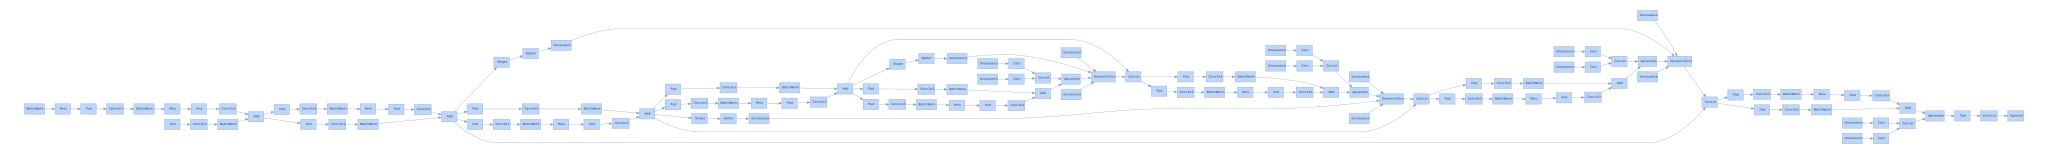

In [6]:
import hiddenlayer as hl
res=resunet(3)
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
x=torch.randn((10,3,560,640))
graph = hl.build_graph(res,x, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph

In [ ]:
res=resunet(3)
LOSS = []

epochs = 10
optimizer = optim.Adam(res.parameters(), lr=0.1)
def train_model(epochs):    
    for epoch in range(epochs):
        print("Training Epoch: "+str(epoch))
        for x,y in dataload:
            #print(x.size())
            yhat = res(x)
            loss = dice_loss(y,yhat)
            LOSS.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Epoch '+str(epoch)+'Loss: 'LOSS[-1])
train_model(epochs)